In [1]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, insert_zero_params, rescale_manybody_params
from statmechlib.preprocessing import Trajectory, find_index, pair_dist_cutoff, universal_eos, downselect
from statmechlib.forcefields import utot_EAM_per_atom, utot_EAM_per_box, udif_print, u_core
from statmechlib.read_write import params_to_pickle

In [4]:
target_proc = '../data/target_processed'
working = '../data/working'
reports = '../reports'
pot_path = '../sim/potentials'

In [5]:
# params_file = 'marinica_params'
stats_file = 'stats_manyall' # 'stats_samples'
target_file = 'target_manyall' # 'target_samples'
params_file = 'params_out'
params_old = 'params_optimal'

In [38]:
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_all = pickle.load(fi)

with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)  
    
# original marinica params
with open(os.path.join(working, params_old + '.pickle'), 'rb') as fi:
    param_list_old = pickle.load(fi)  

In [39]:
param_list = [param_list_old[0]] + param_list[:1]
print(len(param_list))

2


In [40]:
stats_list = []
for pars in param_list:
    pair_knots = pars['hyperparams']['pair']
    edens_knots = pars['hyperparams']['edens']
    stats_list.append(downselect(stats_all, pair_knots, edens_knots))

In [41]:
# for key in sorted(targets.keys()):
#     for box, xyz, ene in zip(targets[key]['box'], targets[key]['xyz'], stats[key]['energy']):
#         n = len(xyz)
#         vol = np.linalg.det(box)
#         corr = float(n*n)/vol
#         ene.append([corr])

In [42]:
def plot_udif(targets, stats_list, params_list, traj_name, select=slice(None, None, None), x_lim=None, y_lim=None, x_ticks=None, shift=0.0, fname=None, verbose=0):
    
    plt.figure(figsize=(20,10))

    plt.title(traj_name, fontsize=30)
    
    # get target energies
    pars = to_param_list(params_list[0]['params'])
    opti_out, targ_out = udif_print(pars, targets, stats_list[0], utot_EAM_per_atom)

    #number of atoms in each configuration of this trajectory
    nat = np.array([len(x) for x in targets[traj_name]['xyz']])[select]
    
    # plot target energies
    #plt.plot(np.array(targ_out[traj_name])[select]/nat, 'o', label='target', markersize=5)
    plt.plot(np.array(targ_out[traj_name])[select], 'o', label='target', markersize=8)
    if verbose:
        print('u_target:',np.array(targ_out[traj_name])[select] )
        
    if shift == 'auto':
        targ_ene = np.mean(np.array(targ_out[traj_name])[select])

    # get and plot optimized model energies
    for i, (stats, params) in enumerate(zip(stats_list, params_list)):
        pars = to_param_list(params['params'])
        opti_out, targ_out = udif_print(pars, targets, stats, utot_EAM_per_atom)
        
        if shift == 'auto':
            du = targ_ene - np.mean(np.array(opti_out[traj_name])[select])
        else:
            du = shift

        #plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])/nat, 'x--', label='optimized '+str(i))
        plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]]) + du, '.--', lw=2, label='optimized '+str(i))
        if verbose:
            print('u_model', i,':', [o for o in np.array(opti_out[traj_name])[select]])
    plt.legend(loc='best')#fontsize=30)
    
    # special requirements on axes
    if x_lim:
        plt.xlim(*x_lim)
    if y_lim:
        plt.ylim(*y_lim)
    if x_ticks:
        plt.xticks(*x_ticks)
    
    plt.xlabel('configuration #', fontsize=30)
    plt.ylabel('Energy [eV]', fontsize=30)
    
    plt.grid(True)
    
    if fname:
        file_name = fname
    else:
        file_name = traj_name
        
    
    plt.savefig(os.path.join(reports, file_name+'.png'))

('u_target:', array([-1139.2       ,  -907.01548795, -1136.40101438, -1136.75081873,
       -1190.26117728, -1127.17469716]))
('u_model', 0, ':', [-1135.521815750772, -910.420440229723, -1136.0040042294886, -1136.1465574140611, -1188.680517051502, -1123.2983174217331])
('u_model', 1, ':', [-1137.9052683163502, -910.90928342800589, -1135.291720014133, -1135.7879281240498, -1192.330426345306, -1125.4522553790166])


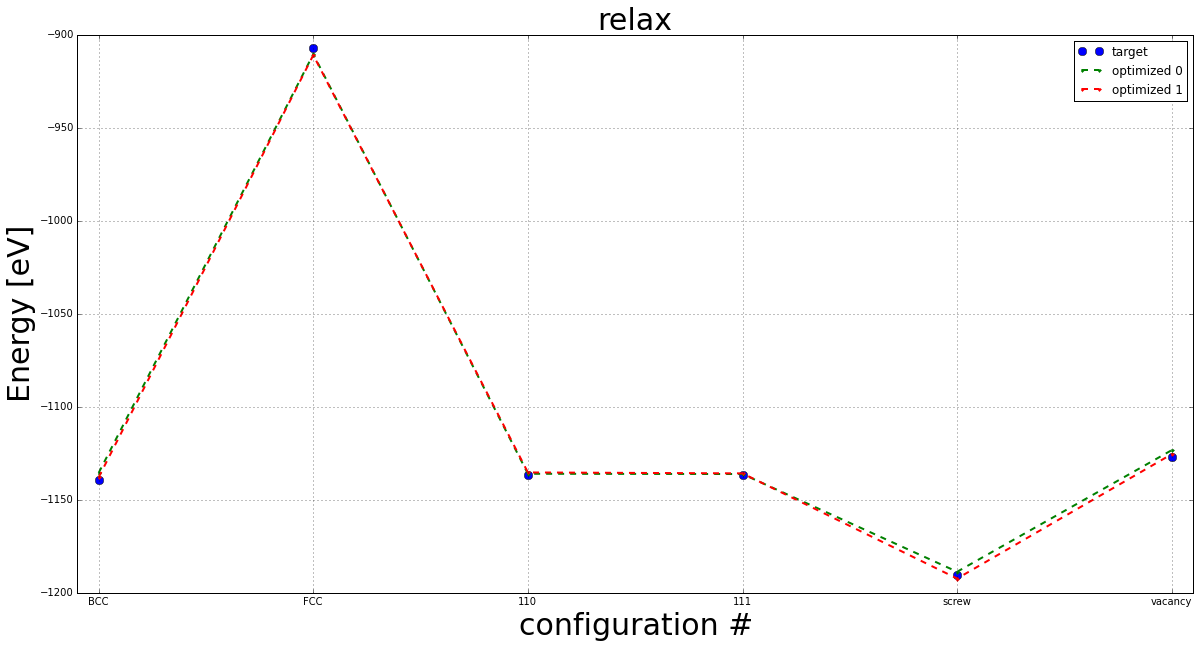

In [43]:
# plot relax
x_ticks = ([0, 1, 2, 3, 4, 5], ['BCC', 'FCC','110','111', 'screw', 'vacancy'])
x_lim=(-0.1, 5.1)
slice_end = len(x_ticks[0])
select = slice(0, slice_end, None)
plot_udif(targets, stats_list, param_list, 'relax', select=select, x_ticks=x_ticks, x_lim=x_lim, shift=0, verbose=1)#-37)#-36)

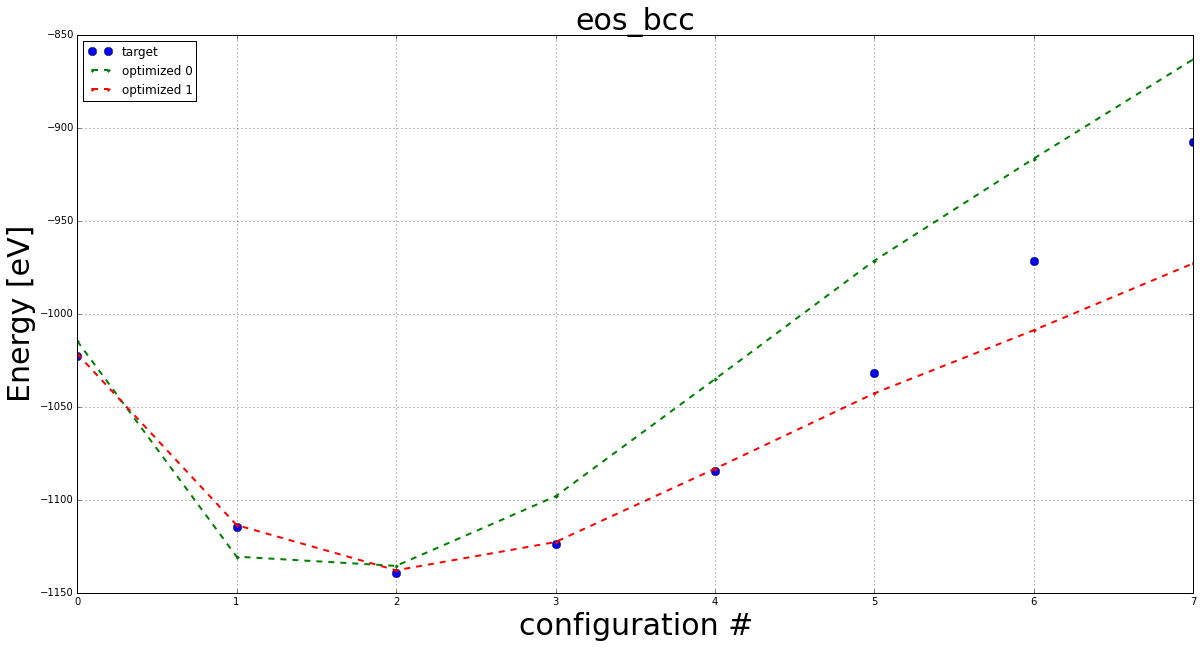

In [44]:
# plot bcc EOS
select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
select = [1, 2, 0, 3, 4, 5, 6, 7]
x_lim = (2, 8)
y_lim = (-9.0, -7.0)
plot_udif(targets, stats_list, param_list, 'eos_bcc', select=select, shift=0)#, verbose=1)#-37)#-36)

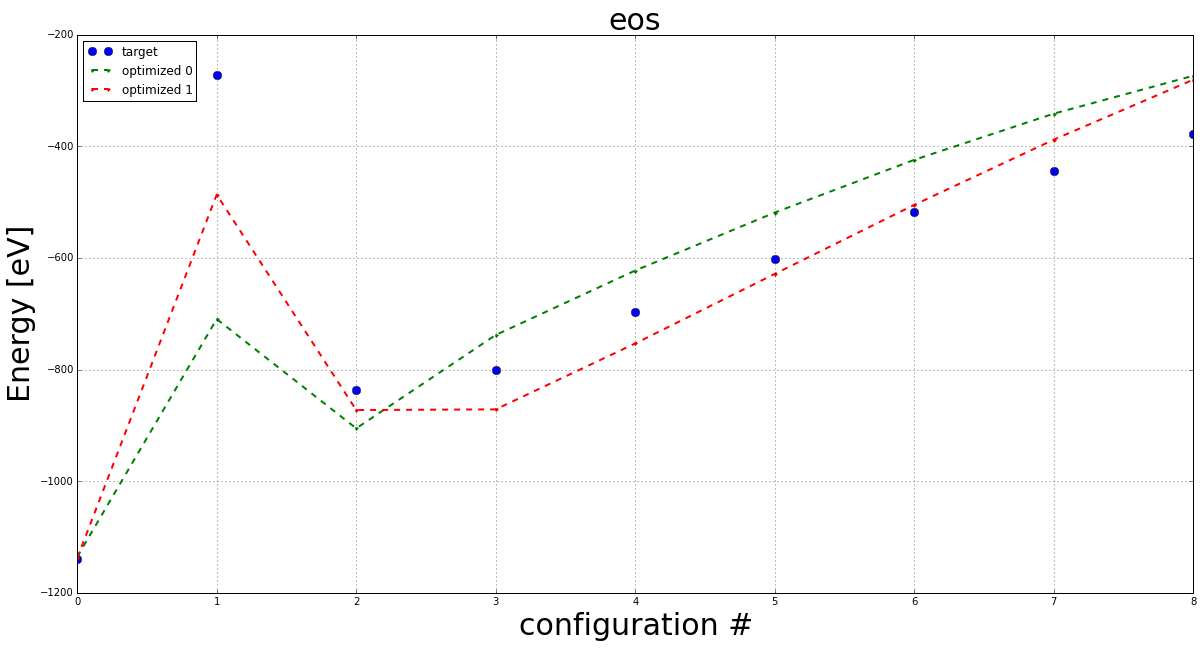

In [45]:
#select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
#x_lim = (2, 8)
#y_lim = (-9.0, -7.0)
plot_udif(targets, stats_list, param_list, 'eos', shift=0)#, verbose=1)#-37)#-36)

In [46]:
# # plot fcc EOS
# #select = [1, 2, 3, 0, 5, 6, 7, 4]
# select = [1, 2, 0, 3, 4]
# x_lim = (0, 4)
# y_lim = (-950, -800)
# plot_udif(targets, stats_list, param_list, 'eos_fcc', x_lim=x_lim, y_lim=y_lim, select=select)

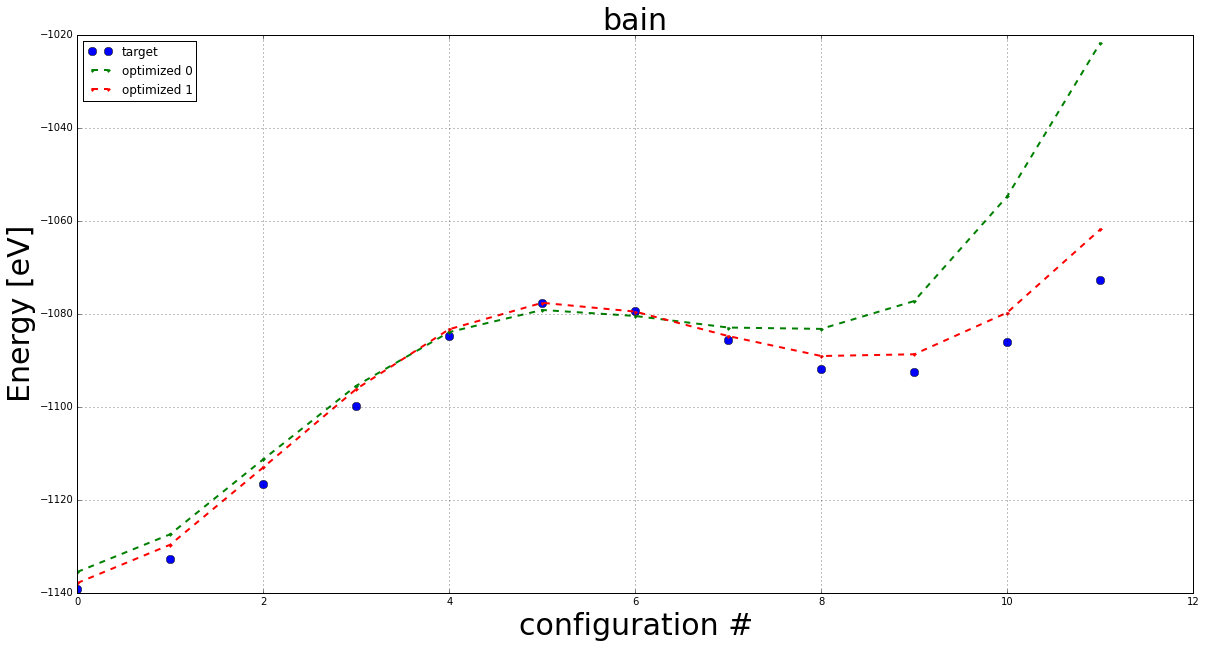

In [47]:
# plot bain path
plot_udif(targets, stats_list, param_list, 'bain')

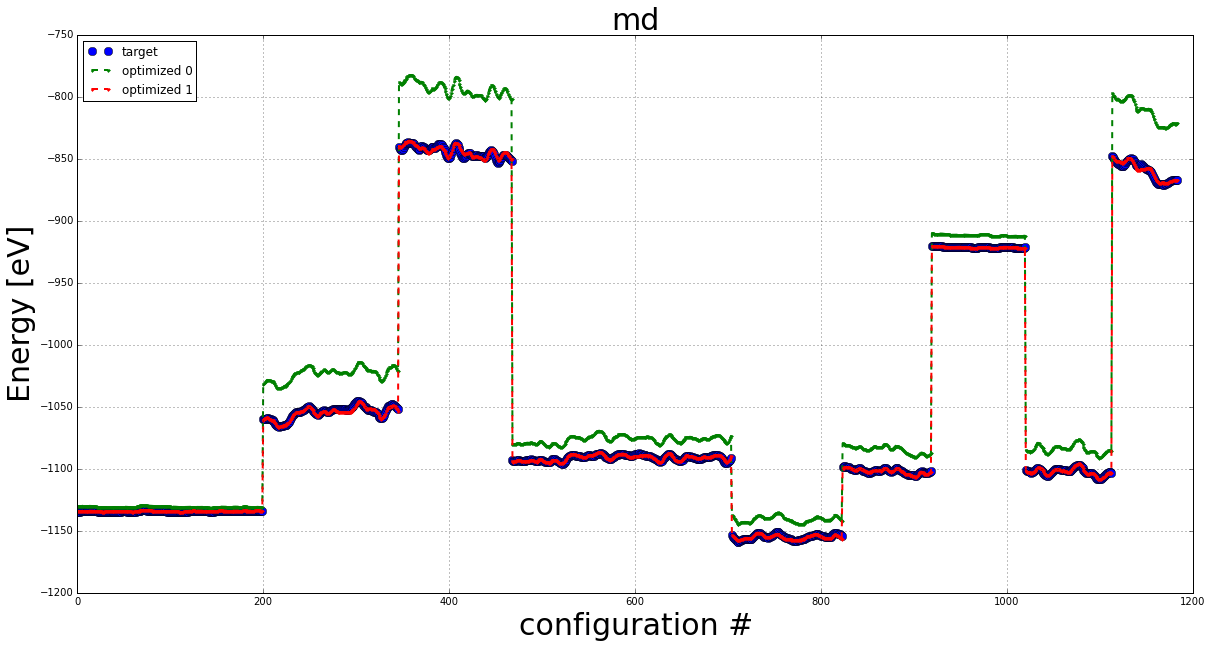

In [48]:
# all trajectories together
x_lim = (0, 1200)
y_lim = (-1180, -750)
plot_udif(targets, stats_list, param_list, 'md')

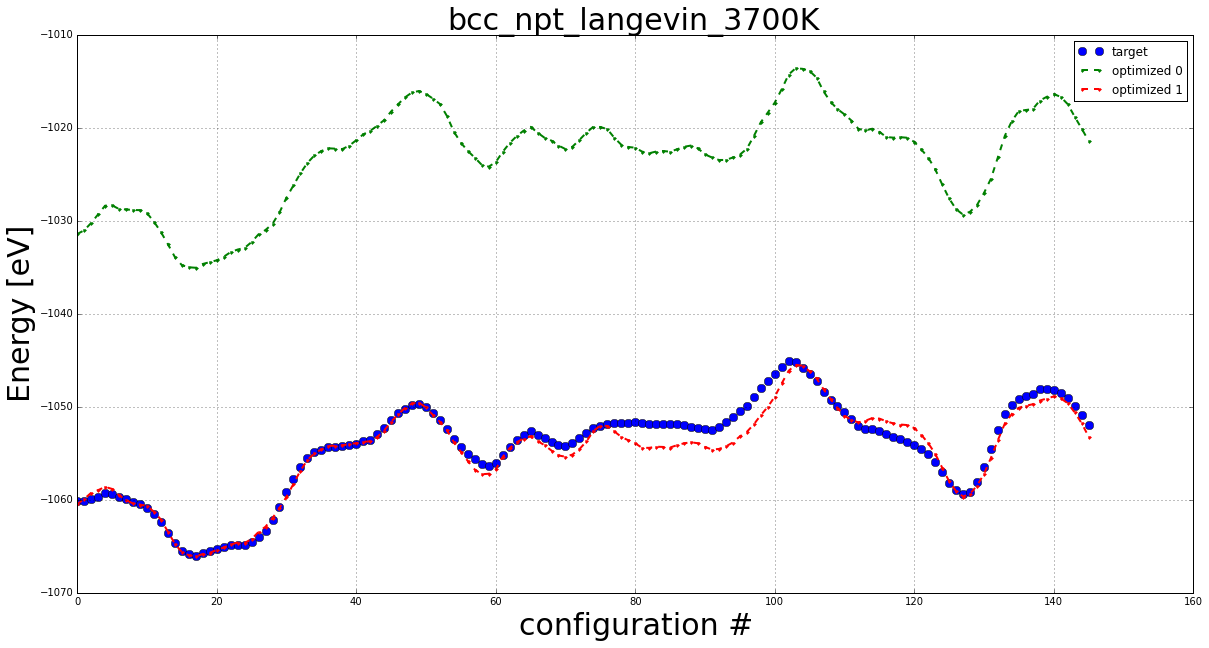

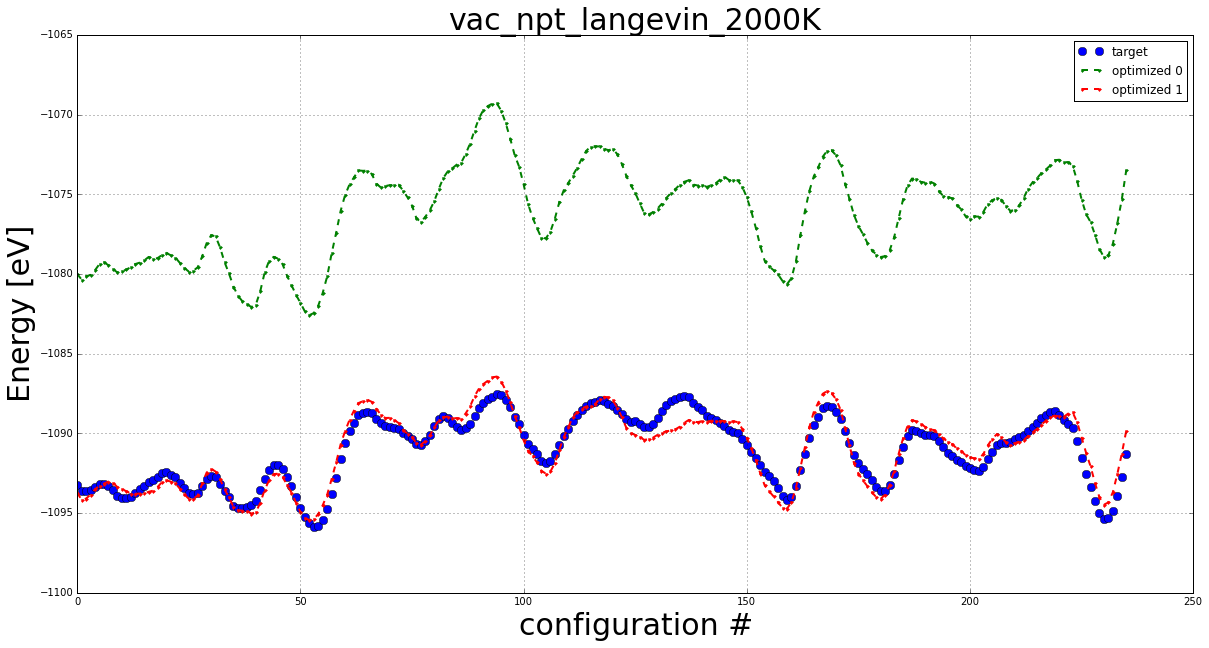

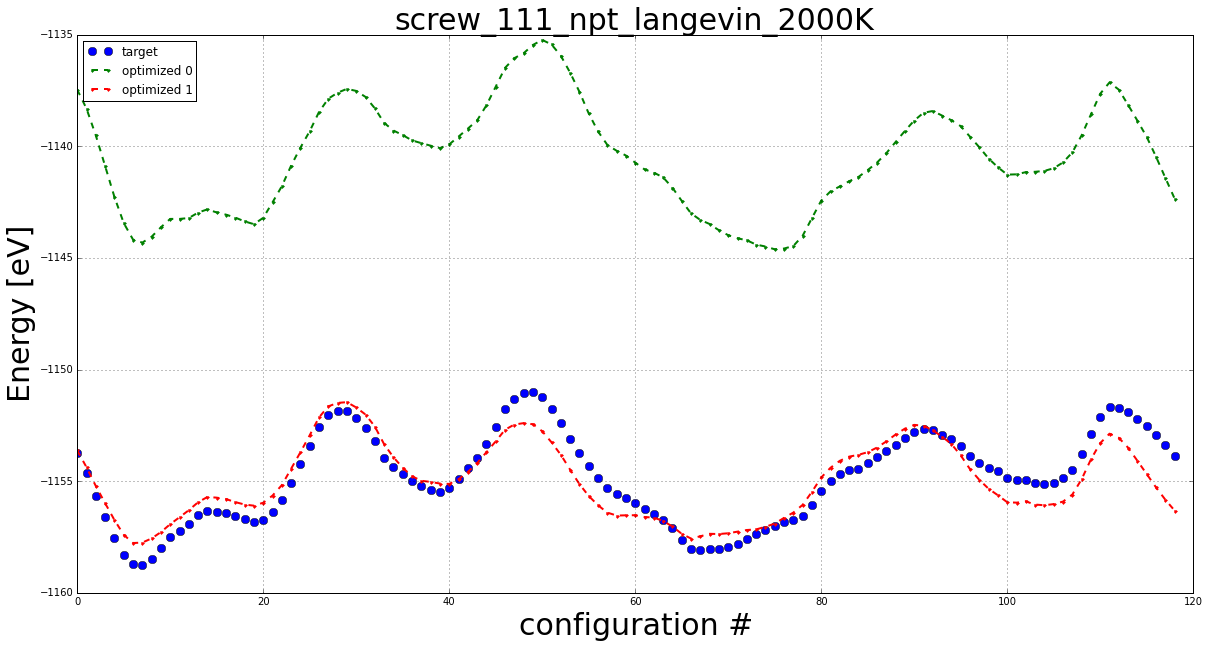

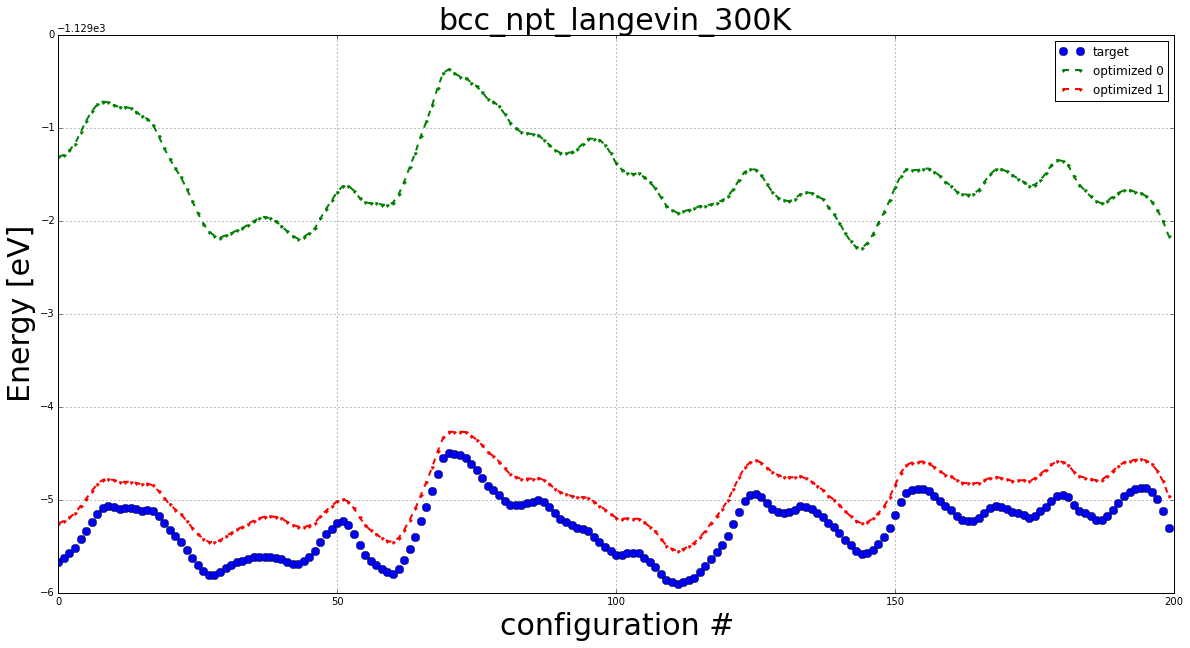

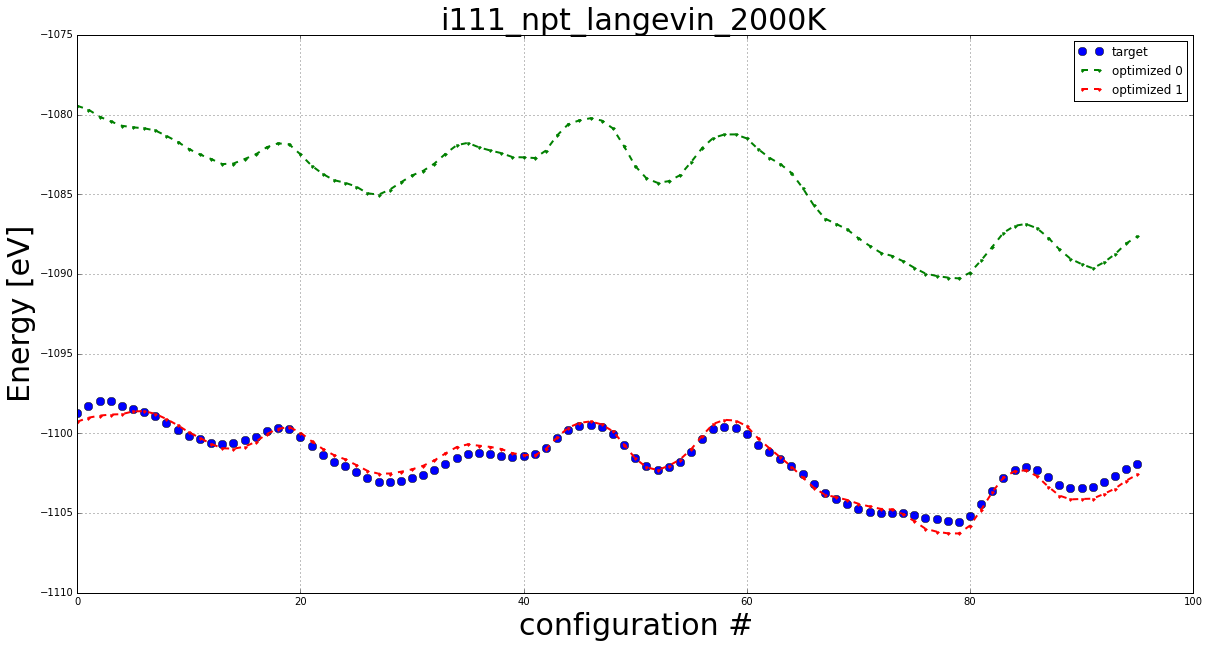

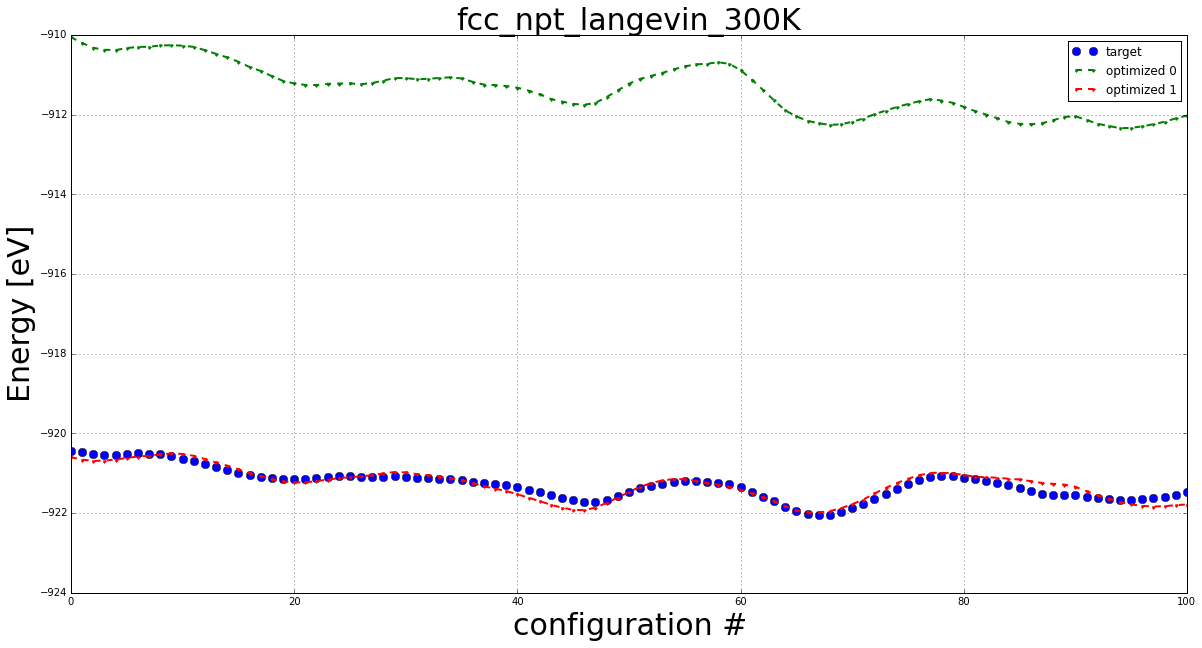

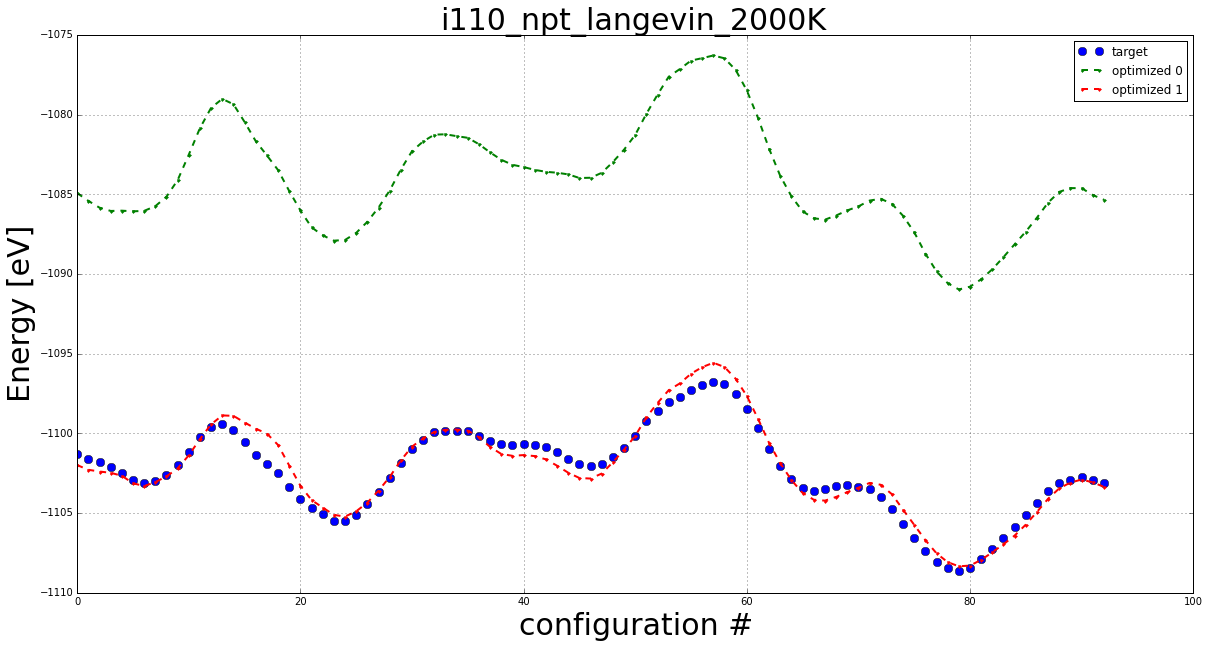

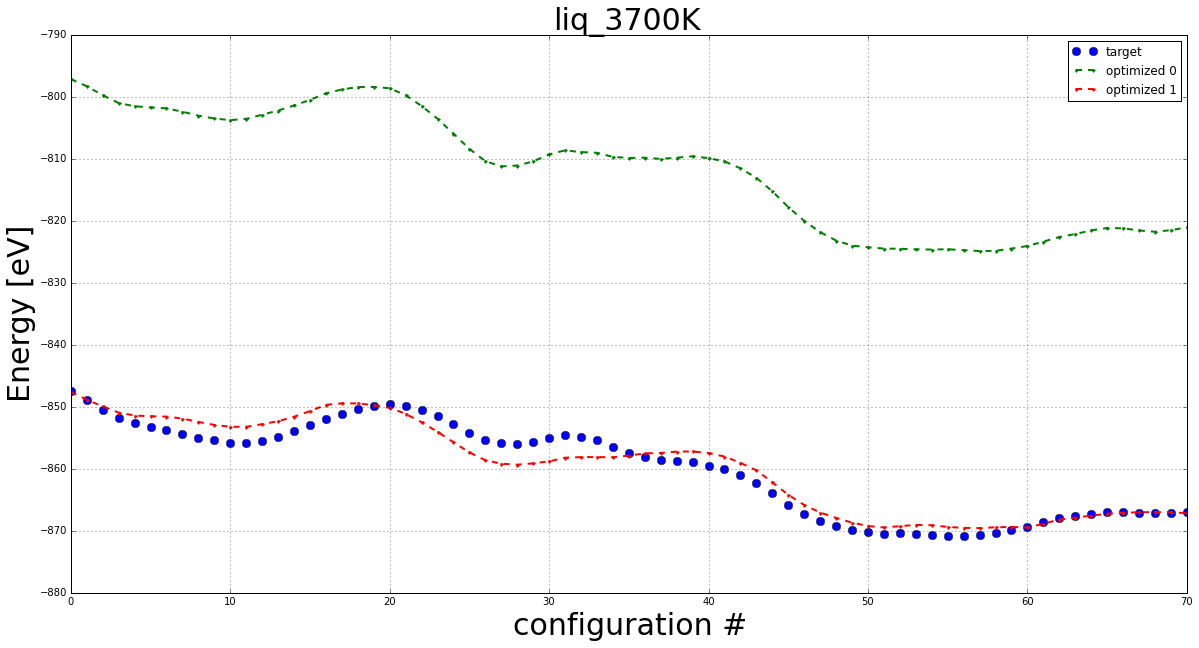

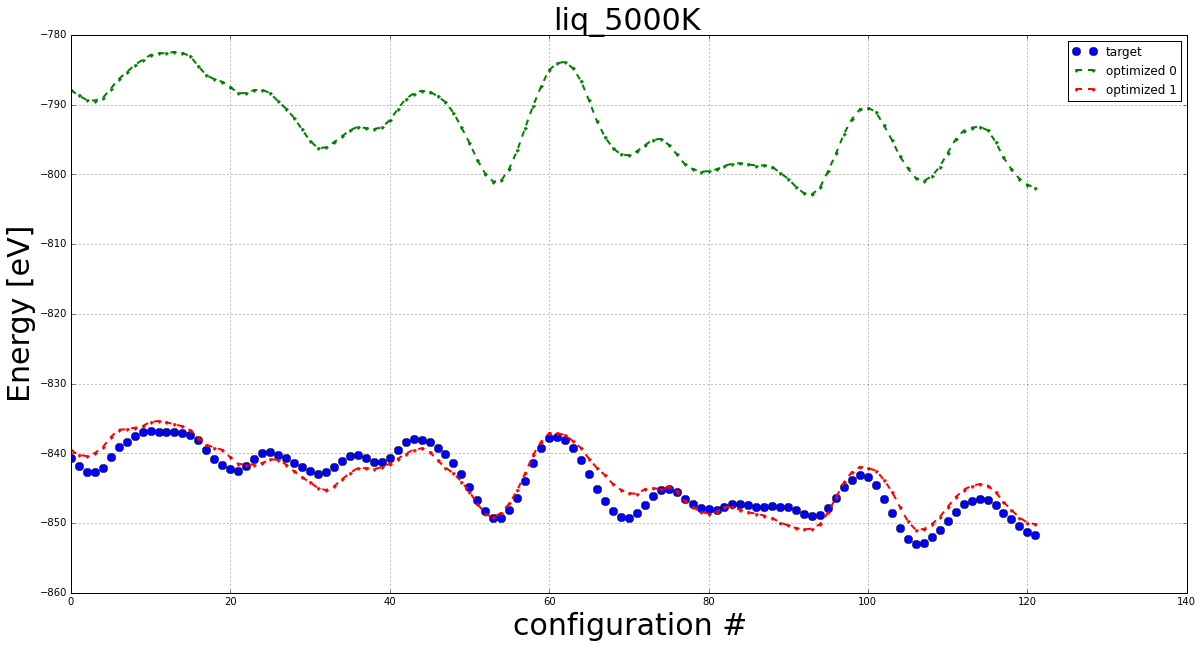

In [49]:
# individual trajectories
for traj in targets.keys():
    if 'npt' in traj or 'liq' in traj:
        plot_udif(targets, stats_list, param_list, traj)

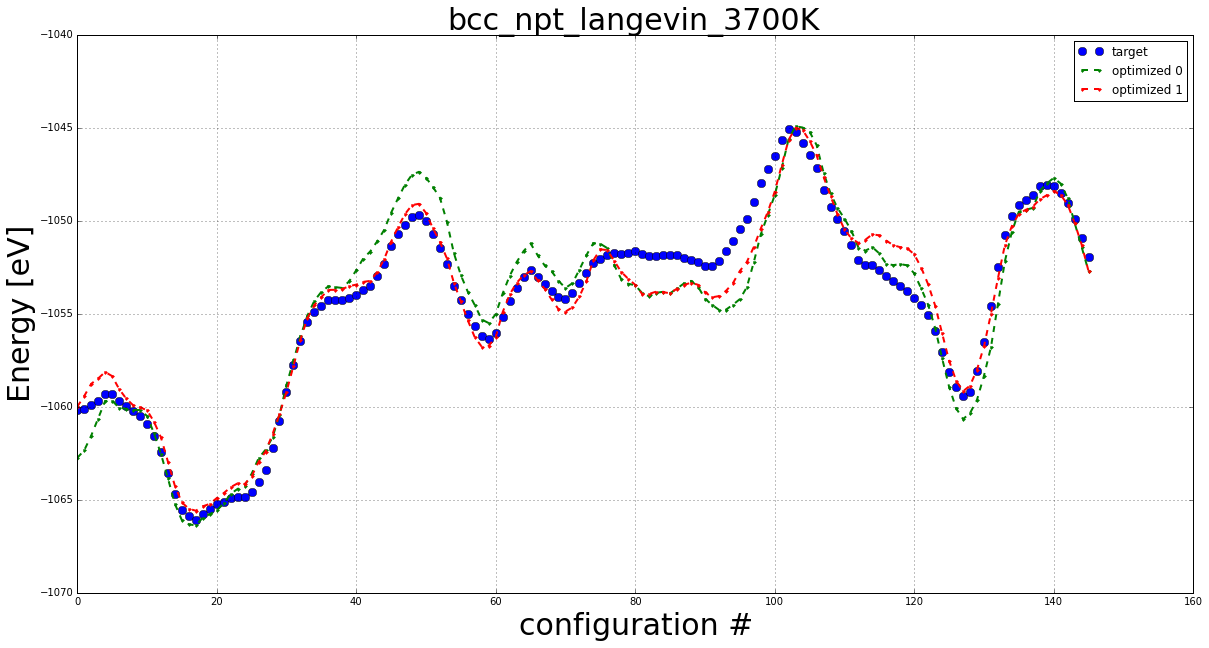

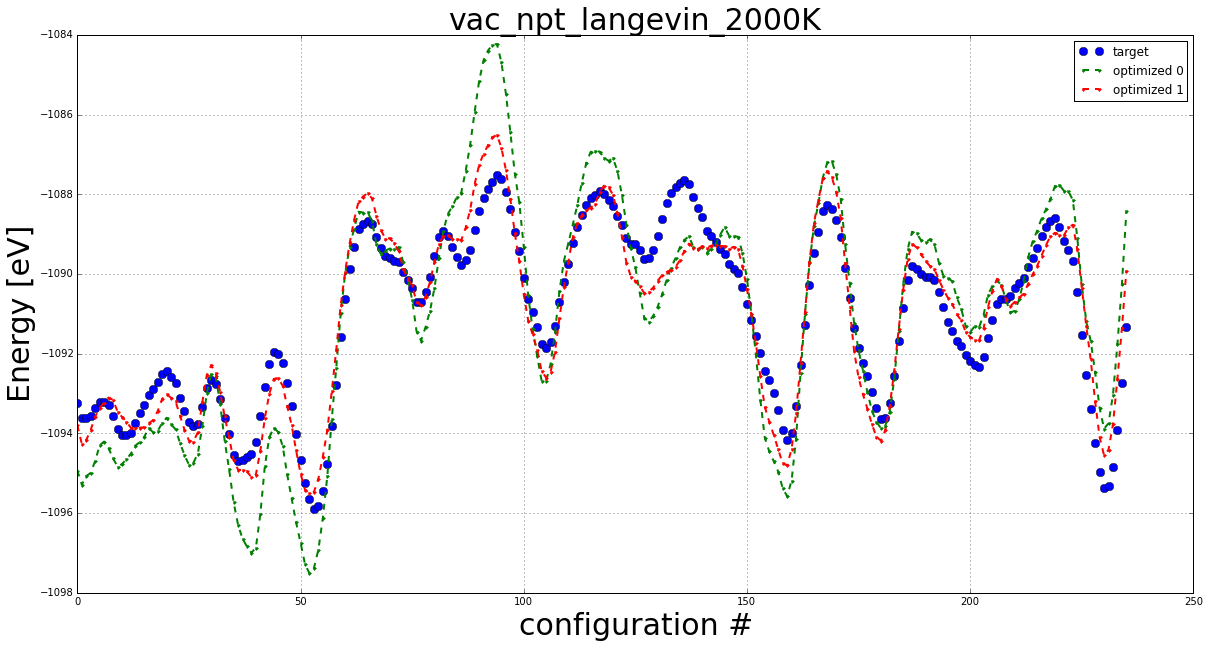

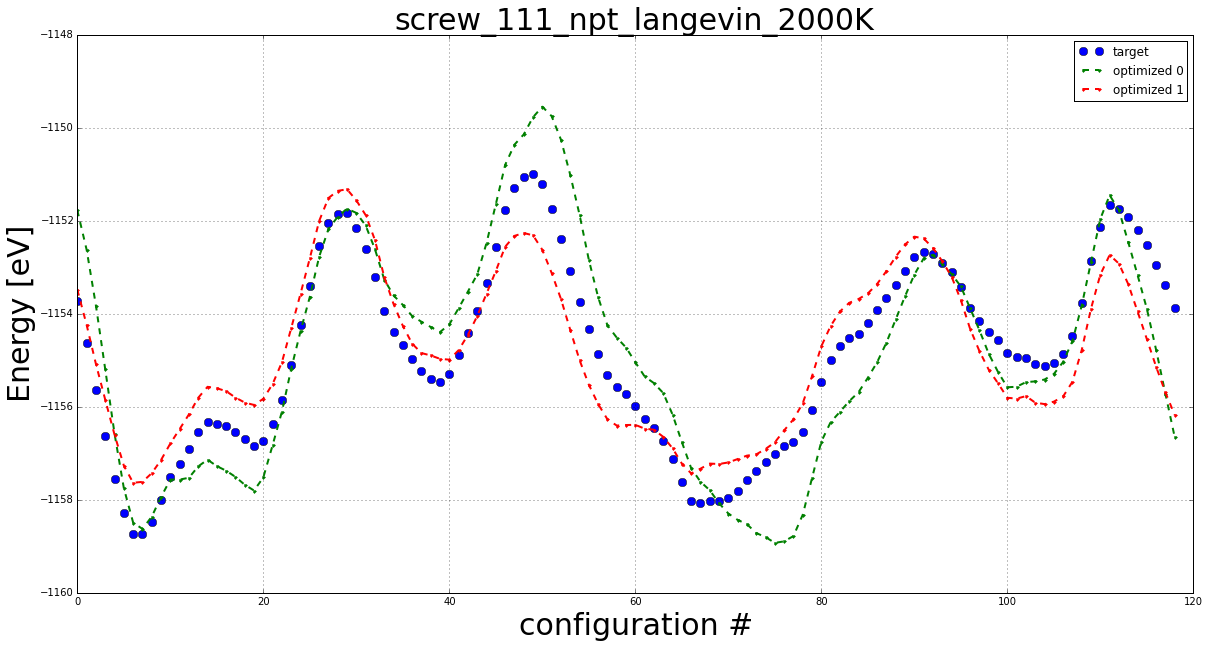

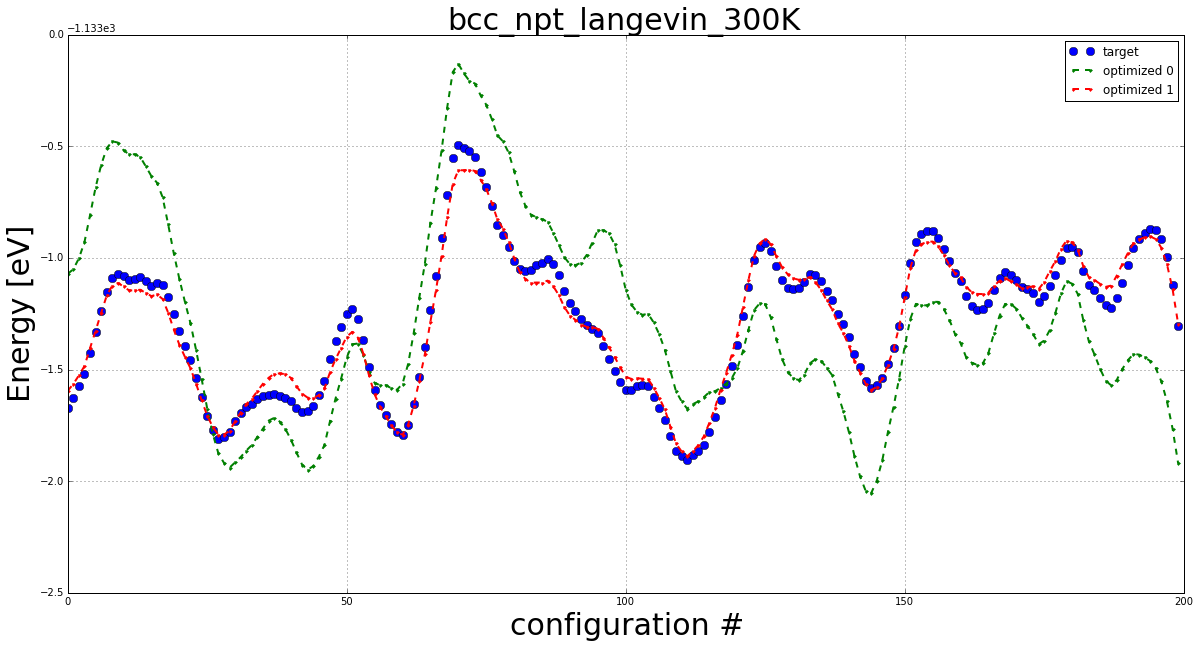

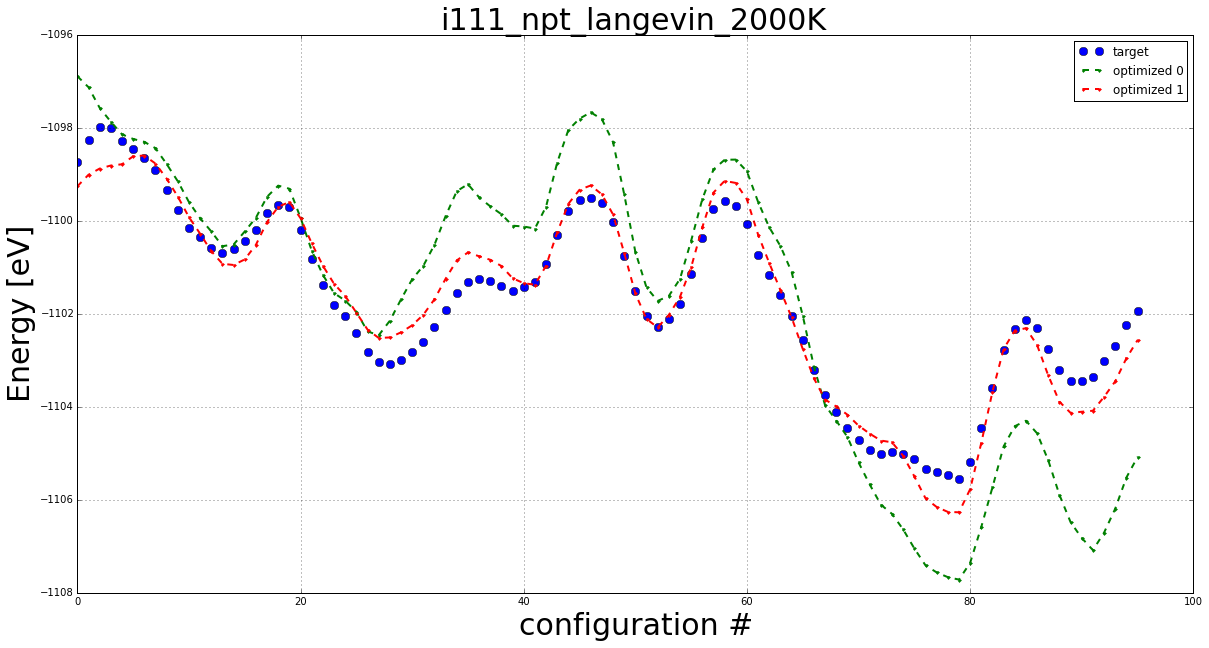

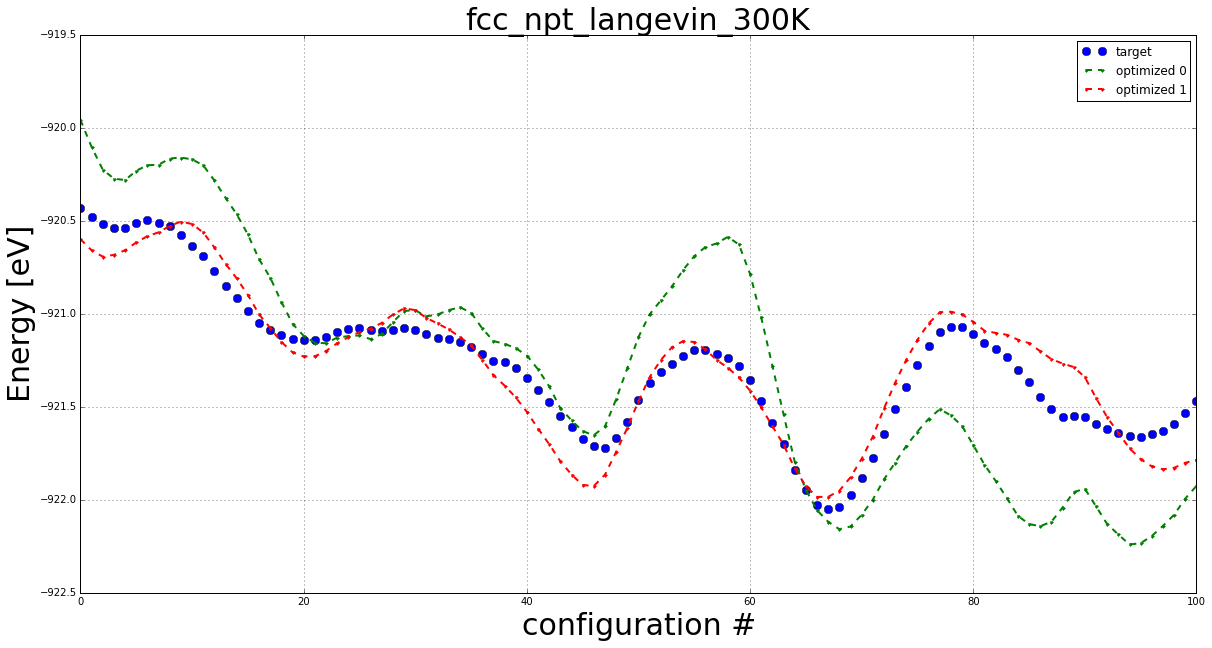

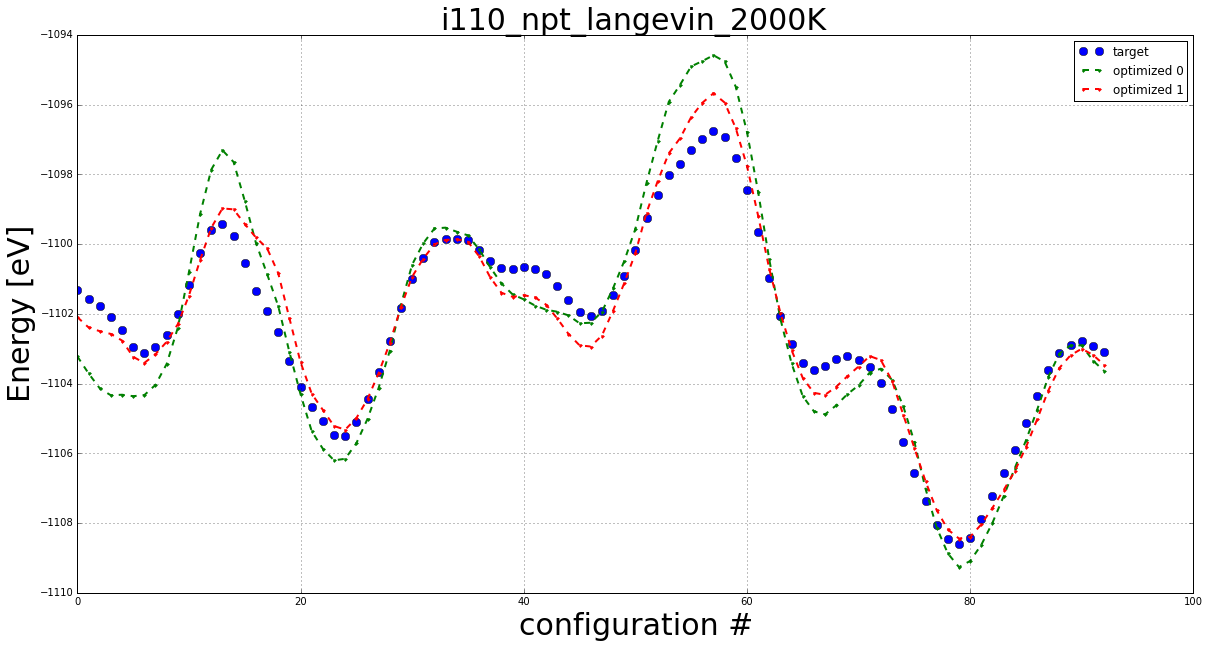

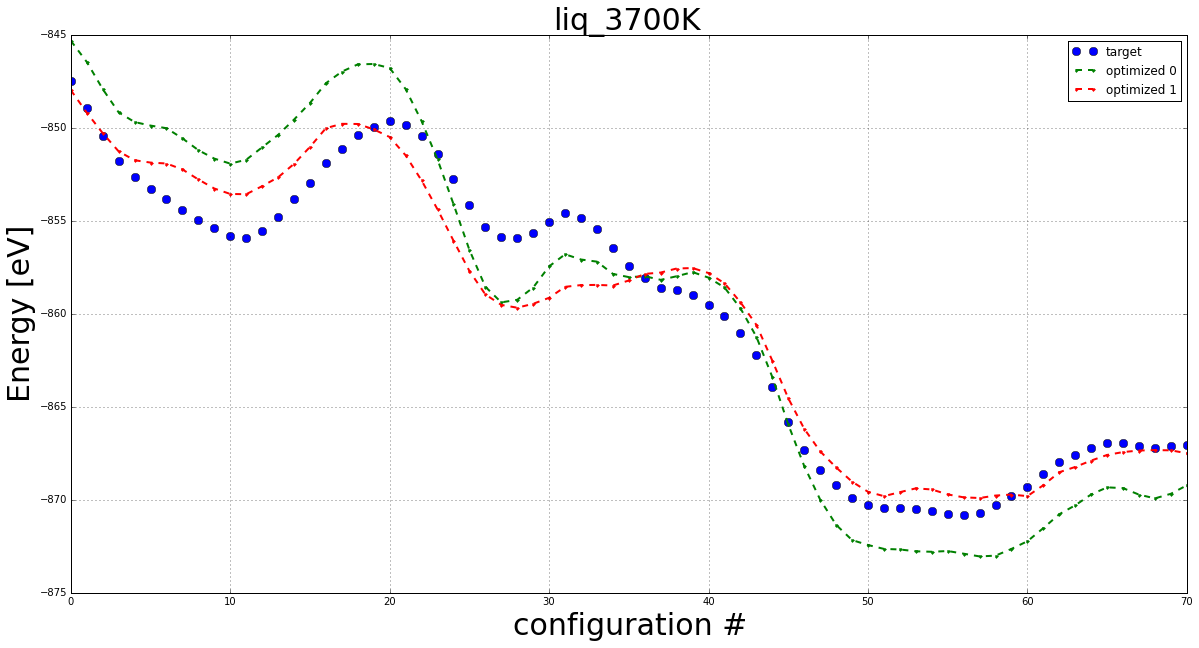

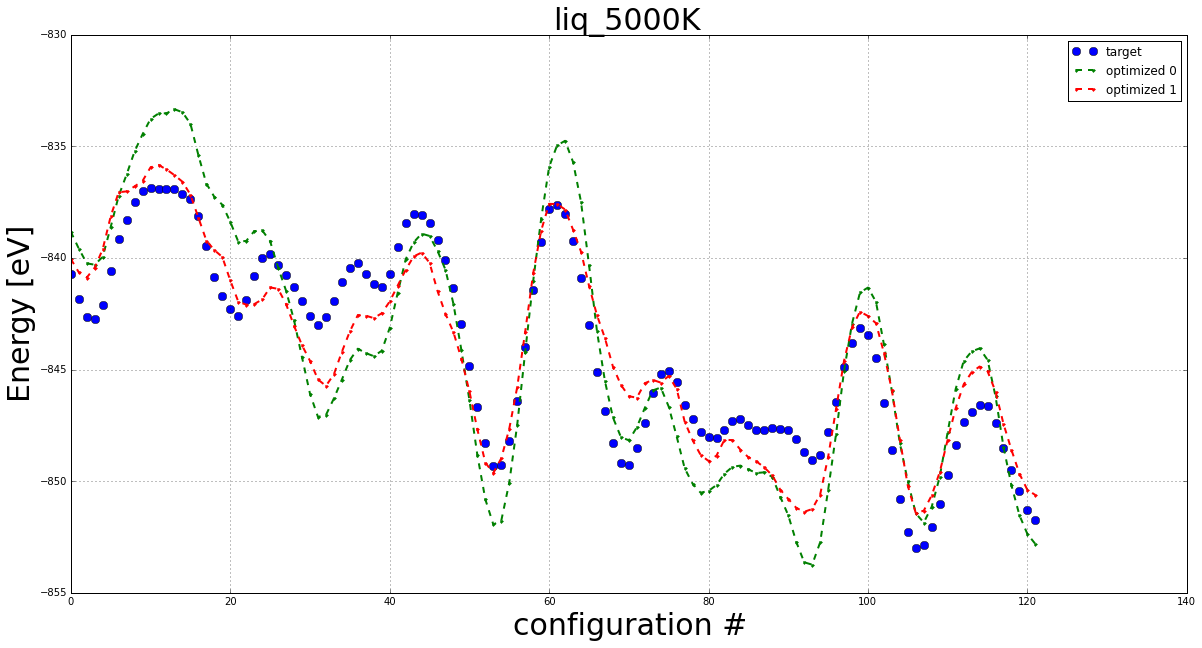

In [50]:
# individual trajectories adjusted for marinica
for traj in targets.keys():
    if 'npt' in traj or 'liq' in traj:
        plot_udif(targets, stats_list, param_list, traj, shift='auto', fname=traj+'adjust')

In [52]:
# Total pair potential
pos = targets['relax']['xyz'][0]
bx = targets['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [53]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc and r > 0.01])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [54]:
def eos_ene(param_dict, rrs):
    
    # spline knots
    V_x_r = param_dict['hyperparams']['pair']
    rho_x_r = param_dict['hyperparams']['edens']

    # parameters
    pair_y = param_dict['params']['pair']
    many_y = param_dict['params']['embed']
    rho_x_a = param_dict['params']['edens']

    ene = []
    for a in np.linspace(0.5, 2.0, 101):
        z = a*rrs
        u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

        u_many = 0.0
        for i in range(z.shape[0]):
            d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
            u_many += F(d, many_y)

        ene.append([a, u_pair, u_many, u_pair+u_many])

    return np.array(ene)

In [55]:
ene_eos = []
for pars, stats in zip(param_list, stats_list):
    ene_eos.append(eos_ene(pars, rr))

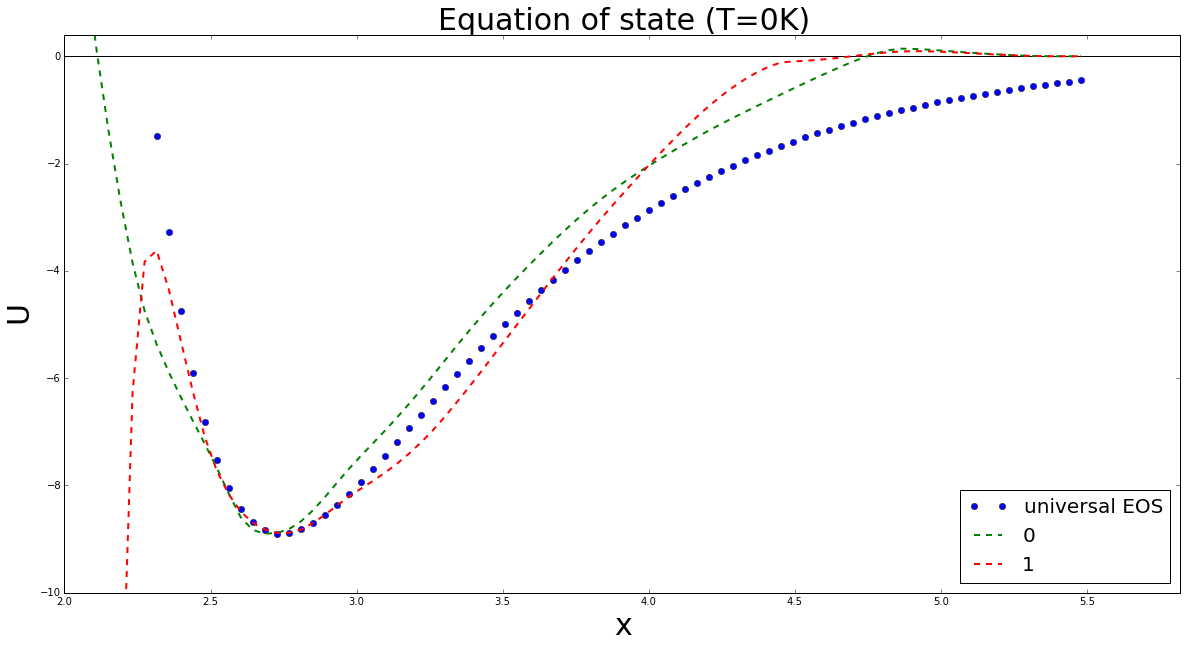

In [57]:
plt.figure(figsize=(20,10))

plt.title('Equation of state (T=0K)', fontsize=30)

plt.plot(ene_eos[0][:,0]*2.74, [universal_eos(x, 'W') for x in ene_eos[0][:,0]], 'o', label='universal EOS')
for i in range(len(param_list)): 
    plt.plot(ene_eos[i][:,0]*2.74, ene_eos[i][:,3]/128,'--', lw=2, label=str(i))

#plt.scatter(stats['hyperparams']['pair'], np.zeros(len(stats['hyperparams']['pair'])))
#plt.vlines(stats['hyperparams']['pair']+[5.66], -10, 0)
#plt.vlines(stats['hyperparams']['edens'], -10, 0, colors='m')

#plt.vlines(np.linspace(2.25, 5.5, 14), -10, 0, colors='r')
#plt.vlines([2.26, 2.5 , 2.66, 2.74, 2.86, 3.06, 3.30, 3.62 , 3.9, 4.22, 4.54, 4.86, 5.18, 5.5], -10, 0, colors='g')

plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend(loc='best', fontsize=20)
plt.xlim(2.0, 5.82)
#plt.xlim(2.5, 3.)
plt.ylim(-10,0.4)
#plt.ylim(-9.,-8.)

plt.xlabel('x', fontsize=30)
plt.ylabel(r'U', fontsize=30)
plt.savefig(os.path.join(reports, 'universal_eos'+'.png'))

In [58]:
file_name = os.path.join(working, "params_optimal.pickle")

for params in param_list[1:]:
    params_to_pickle(params, file_name)

In [59]:
with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [476]:
ff_id = -1

# spline knots
pair_r = stats['hyperparams']['pair']
rho_r = stats['hyperparams']['edens']

# parameters
pair_a = param_list[ff_id]['params']['pair']
rho_a = param_list[ff_id]['params']['edens']
many_a = param_list[ff_id]['params']['embed']

In [477]:
print(many_a)

[ -3.36853915e+00   8.06754487e-04]


In [1393]:
# find electronic density maximum
rmax = max([(phi(r, rho_a, rho_r), r) for r in np.linspace(2.0, 4.9, 10000)])
rho_max, r_max = rmax
rho_max, r_max
rhomax = 12.0*phi(r_max, rho_a, rho_r)
rmax, rhomax

((22.085469153498732, 2.0), 265.02562984198477)

In [1394]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(r_max, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 10.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

('rhomax:', 265.02562984198477)


In [1395]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [1396]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) if x > r_max else rho_max for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [1397]:
# LAMMPS format

with open(os.path.join(pot_path, 'W_zeroenx.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    #fo.write(f"{n_el:5d} ")
    fo.write("{0:5d} ".format(n_el))

    for i in range(n_el):
        #fo.write(f"{el_name[i]:2}")
        fo.write("{0:2}".format(el_name[i]))
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    #fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    fo.write("{0:5d}{1:24.16e}{2:5d}{3:24.16e}{4:24.16e}\n".format(nrho, drho, nr, dr, rcut))

    # atomic number, mass, lattice size, lattice type
    #fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    fo.write("{0:5d} {1:14.4f} {2:14.4f} {3:10}\n".format(na, ma, lc, alat))

    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))

In [ ]:
# Yuri's format

with open(os.path.join(pot_path, 'W_pair.yuri'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    #fo.write(f"{n_el:5d} ")
    fo.write("{0:5d} ".format(n_el))

    for i in range(n_el):
        #fo.write(f"{el_name[i]:2}")
        fo.write("{0:2}".format(el_name[i]))
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    #fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    fo.write("{0:5d}{1:24.16e}{2:5d}{3:24.16e}{4:24.16e}\n".format(nrho, drho, nr, dr, rcut))

    # atomic number, mass, lattice size, lattice type
    #fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    fo.write("{0:5d} {1:14.4f} {2:14.4f} {3:10}\n".format(na, ma, lc, alat))

    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))